![logo](https://github.com/donatellacea/DL_tutorials/blob/main/notebooks/figures/1128-191-max.png?raw=true)

# XAI in Deep Learning-Based Signal Analysis: The Class Activation Map (CAM)

In this Notebook, we will delve into the utilization of CAM to reveal the sections of a signal that a ResNet-50 model trained on signal data considers crucial during its prediction process.

--------

## Getting Started

### Setup Colab environment

If you installed the packages and requirements on your own machine, you can skip this section and start from the import section.
Otherwise, you can follow and execute the tutorial on your browser. In order to start working on the notebook, click on the following button, this will open this page in the Colab environment and you will be able to execute the code on your own.

<a href="https://colab.research.google.com/github/HelmholtzAI-Consultants-Munich/Zero2Hero---Introduction-to-XAI/blob/Juelich-2023/xai-model-for-1d-data/Tutorial_CAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Now that you opened the notebook in Colab, follow the next step:

1. Run this cell to connect your Google Drive to Colab and install packages
2. Allow this notebook to access your Google Drive files. Click on 'Yes', and select your account.
3. "Google Drive for desktop wants to access your Google Account". Click on 'Allow'.
   
At this point, a folder has been created in your Drive and you can navigate it through the lefthand panel in Colab, you might also have received an email that informs you about the access on your Google Drive.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive
!git clone --branch Juelich-2023 https://github.com/HelmholtzAI-Consultants-Munich/XAI-Tutorials.git
%cd XAI-Tutorials/xai-model-for-1d-data
# TODO: install packages not already present in Colab, e.g. %pip install lime

### Imports, data and model loading

In [1]:
%matplotlib inline
import sys 
import math
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader

sys.path.append('../data_and_models')
from ResNet1D import ResNet, ResNetBlock
from ECG import ECG

We fix the random seeds to ensure reproducible results as we work with (pseudo) random numbers.

In [2]:
# assert reproducible random number generation
seed = 1
np.random.seed(seed)
torch.manual_seed(seed)

Let's set some paths. We provide the path of the model's weight and the location of the test data. 

In [3]:
model_weights_path = '../data_and_models/weights/model_weights9.pth'
test_data_path = '../data_and_models/Dataset-ECG/mitbih_test.csv'

We have trained a ResNet-50 model for 10 epochs on the Electrocardiogram (ECG) Heartbeat Categorization Dataset. The ResNet-50 uses conv1d layers instead of conv2d layers. 

The dataset is made up of two groups of heartbeat signals, originating from two well-known heartbeat classification datasets - the MIT-BIH Arrhythmia Dataset and The PTB Diagnostic ECG Database. We used the MIT-BIH Arrhythmia Dataset to train our model. This dataset consists of 87554 samples for train, 21892 samples for test, and 5 categories (['N': 0, 'S': 1, 'V': 2, 'F': 3, 'Q': 4])

The dataset is organized in CSV files. Inside every CSV file, there's a matrix structure. Each row in the matrix signifies an individual ECG signal instance. The last column in each row determines the specific category the example belongs to. For more details about the dataset, please refer to [1].

Consequently, we have created an ECG class that loads the dataset.

In [4]:
ecg = ECG(test_data_path)

Now, let's load our trained model.

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ResNet(ResNetBlock, [2, 2, 2, 2], num_classes=5)
model = model.to(device)
model.load_state_dict(torch.load(model_weights_path, map_location=torch.device(device=device)))

<All keys matched successfully>

#### Generating a Class Activation Map (CAM)

To generate a Class Activation Map (CAM) in a Convolutional Neural Network (CNN), we follow these steps:

#### Step 1: Train a CNN

First, train a CNN. This network typically includes several convolutional layers and is usually followed by fully connected layers, leading to a softmax output for classification.

#### Step 2: Modify the Network for CAM

Modify the network architecture by replacing the fully connected layers with global average pooling (GAP), followed by a softmax layer. The architecture should look like this:

- Convolutional layers
- Global Average Pooling (GAP)
- Softmax layer

#### Step 3: Forward Pass

Perform a forward pass with the input signal through the network. Obtain the feature maps from the last convolutional layer. Denote these feature maps as $ f_k(x, y) $, where $ k $ is the index of the feature map, and $ (x, y) $ are spatial coordinates.

#### Step 4: Obtain the Weights

Extract the weights from the softmax layer. The weight corresponding to class $ c $ for feature map $ k $ is denoted as $ w_k^c $.

#### Step 5: Compute the Class Activation Map

Compute the CAM for a specific class $ c $ using the formula:

$
CAM_c(x, y) = \sum_k w_k^c \cdot f_k(x, y)
$

This formula calculates the CAM as a weighted sum of the feature maps, where the weights are specific to the class $ c $.

#### Step 6: Post-processing

- Resize the CAM to match the size of the input signal.
- Apply a heatmap or color map for better visualization.
- Overlay the CAM on the original signal to identify the regions most relevant for the specific class.

The CAM highlights areas in the input signal that are significant for the CNN's prediction of class $ c $, providing insights into what the network 'sees' as important for its decision-making.

The below figure is taken from the original paper[2] and shows how to generate the CAM from a specific image. 

<img src="..//docs/source/_figures/cam.png" alt="Image Title" width="700" height="700">


In our scenario, the ResNet-50 architecture comprises a series of convolutional layers, succeeded by GAP, a fully connected layer, and a softmax layer. Given this setup, no modifications are required in our model, which facilitates the generation of the CAM.

We create the `return_cam` function that generates a CAM for a specific input and class label using our trained ResNet-50. The function takes as arguments.
The function proceeds as follows:

1. The model processes the input `x`, returning two outputs: `conv_map`, the feature maps from the last convolutional layer, and `logits`, the class scores (before softmax activation).
2. We then create a copy of the feature maps, ensuring they do not impact the computational graph's gradients.
3. Then, we extract weights from the model's fully connected layer `fc`, specifically those associated with the `label`. These weights are crucial for determining the important parts of the feature maps for the specified class.
4. Next, the function reshapes `cam_weights` to align with the dimensions of the feature maps. It then multiplies these reshaped weights with `feature_map`. Following this, the function computes the mean across the feature maps. This operation yields a 2D tensor, which is the CAM. The CAM effectively highlights regions important for predicting the specified class.
5. Finally, we return the generated CAM and logits. 

In [6]:
def return_cam(model, x, label):
    conv_map, logits = model(x)
    feature_map = conv_map.detach().clone()
    cam_weights = model.fc.weight[label]
    cam = (cam_weights.view(*feature_map.shape[:2], 1) *
    feature_map).mean(1, keepdim=False)
    return cam, logits

We code some utility functions—the normalize_scoremap function to normalize the CAM and the t2n function to transform a numpy array to a tensor.

We also have a function named plot_cam that takes the cam and the signal to plot them in a single figure. The code line uses Matplotlib's `imshow` to display a CAM with a red color map (`cmap='Reds'`) over a signal plot. The aspect ratio is set to 'auto' to fit the image to the axes, and `extent` aligns the CAM's dimensions with the signal's length and value range. The CAM is fully opaque (`alpha=1.0`), providing a clear overlay to highlight regions in the signal influential for the model's predictions. 

In [7]:
def normalize_scoremap(cam):
    if np.isnan(cam).any():
        return np.zeros_like(cam)
    if cam.min() == cam.max():
        return np.zeros_like(cam)

    cam -= cam.min()
    cam /= cam.max()
    return cam

def t2n(t):
    return t.detach().cpu().numpy().astype(float)

def plot_cam(cam, signal):
    fig, axs = plt.subplots(figsize=(15,5))
    pcm = axs.imshow(cam, cmap='Reds',  aspect="auto", \
        extent=[0, len(signal[0]), math.floor(signal[0].min()), math.ceil(signal[0].max())], alpha=1.0)
    axs.plot(signal[0], 'k')
    fig.colorbar(pcm, ax=axs, shrink=0.6)
    plt.show()

Let's generate the CAM of the first signal in the test set. Once the CAM is generated, we resize it to the same size as the original signal and normalize the values. We then plot the result.

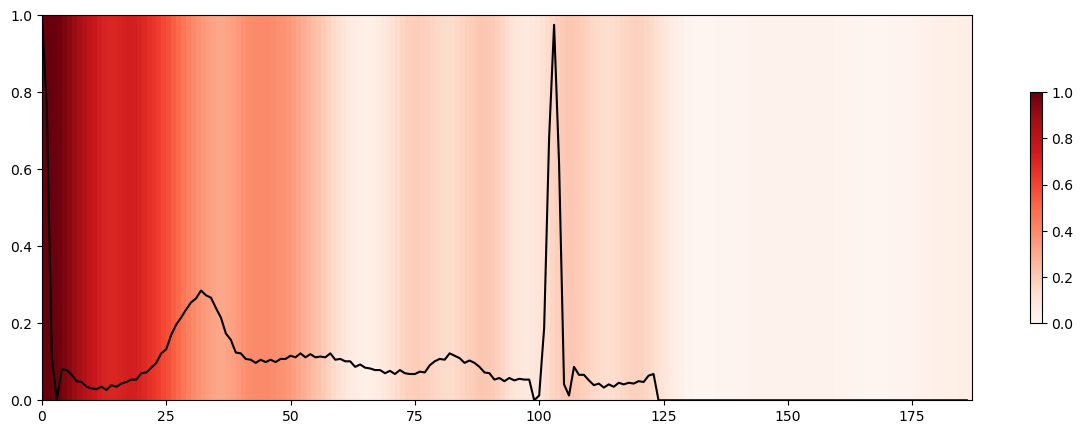

In [8]:
samples = ecg[0]
signal = samples[0]
label = samples[1]

# We unsqueeze the signal to add a batch dimension
cam, logits = return_cam(model, signal.unsqueeze(0).to(device), label)
cam = t2n(cam)

cam_resized = cv2.resize(cam, (signal.shape[-1], 1), interpolation=cv2.INTER_CUBIC)
cam_normalized = normalize_scoremap(cam_resized)  

plot_cam(cam_normalized, signal)

Let's try another example. We generate the CAMs of a batch of signals.

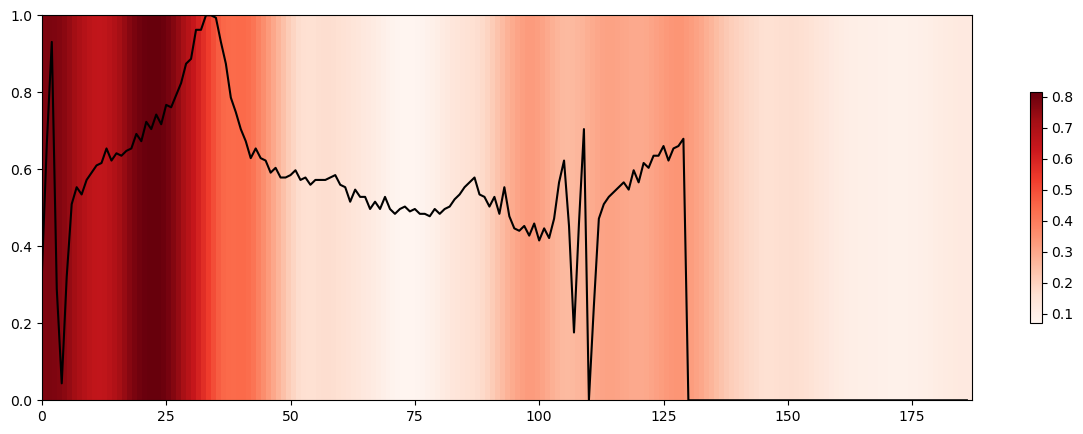

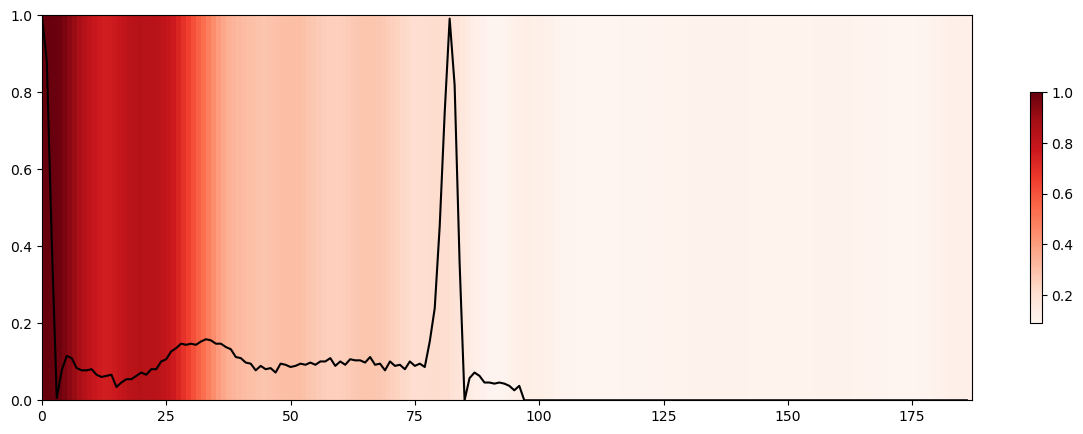

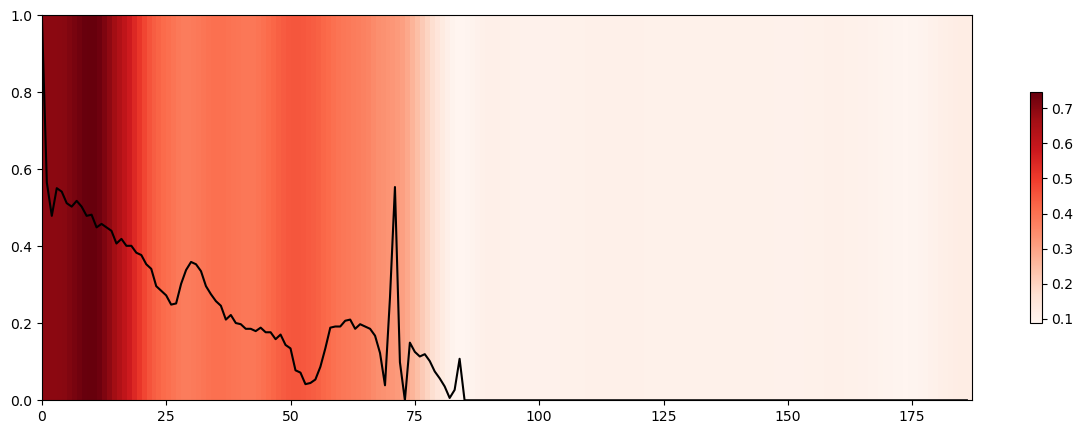

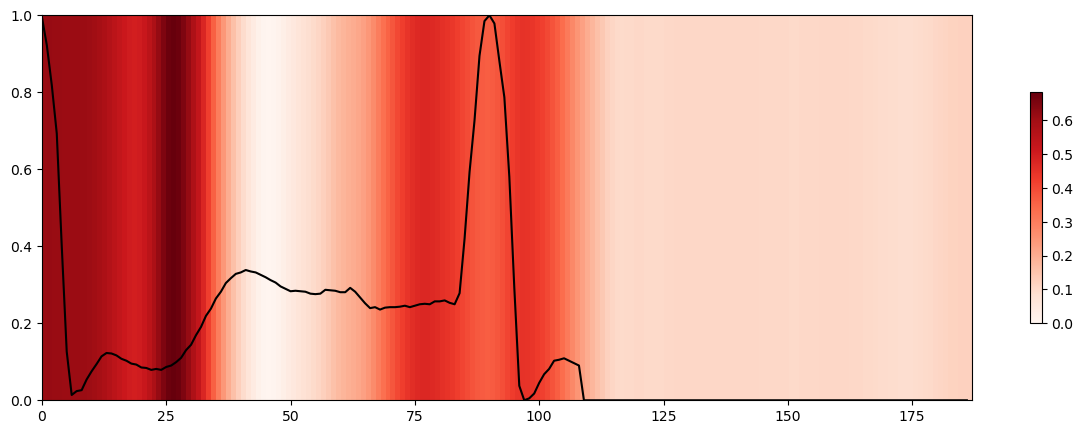

In [9]:
loader = DataLoader(ecg, batch_size=4, shuffle=True, num_workers=2)

for data in loader:

    signal = data[0]
    label = data[1]

    cam, logits = return_cam(model, signal.to(device), label)
    cam = t2n(cam)

    cam_resized = cv2.resize(cam, (signal.shape[-1], cam.shape[0]), interpolation=cv2.INTER_CUBIC)
    cam_normalized = normalize_scoremap(cam_resized)  

    plot_cam(cam_normalized[0:1, :], signal[0])
    plot_cam(cam_normalized[1:2, :], signal[1])
    plot_cam(cam_normalized[2:3, :], signal[2])
    plot_cam(cam_normalized[3:4, :], signal[3])

    break

For more details on the CAM algorithm, please refer to the original paper [2]

## References

[1] Mohammad Kachuee, Shayan Fazeli, and Majid Sarrafzadeh. "ECG Heartbeat Classification: A Deep Transferable Representation." arXiv preprint arXiv:1805.00794 (2018).

[2] Zhou B, Khosla A, Lapedriza A, et al. Learning Deep Features for Discriminative Localization[C]. The IEEE Conference on Computer Vision and Pattern Recognition (CVPR). 2016: 2921-2929.